# loading Bedmachine Antarctica version 1 in to an xarray from the ldeog-glaciology google bucket
https://nsidc.org/data/NSIDC-0756/versions/1

Morlighem, M., E. Rignot, T. Binder, D. D. Blankenship, R. Drews, G. Eagles, O. Eisen, F. Ferraccioli, R. Forsberg, P. Fretwell, V. Goel, J. S. Greenbaum, H. Gudmundsson, J. Guo, V. Helm, C. Hofstede, I. Howat, A. Humbert, W. Jokat, N. B. Karlsson, W. Lee, K. Matsuoka, R. Millan, J. Mouginot, J. Paden, F. Pattyn, J. L. Roberts, S. Rosier, A. Ruppel, H. Seroussi, E. C. Smith, D. Steinhage, B. Sun, M. R. van den Broeke, T. van Ommen, M. van Wessem, and D. A. Young. 2020. Deep glacial troughs and stabilizing ridges unveiled beneath the margins of the Antarctic ice sheet, Nature Geoscience. 13. 132-137. https://doi.org/10.1038/s41561-019-0510-8

In [22]:
import dask
import dask.delayed
from dask.distributed import Client
import dask_gateway
import numpy as np
import xarray as xr
xr.set_options(display_style="html")
import hvplot.xarray
import dask.array as da

## load the netcdf as a dask array (lazily loaded xarray)

In [41]:
import fsspec

url = 'https://storage.googleapis.com/ldeo-glaciology/bedmachine/BedMachineAntarctica_2019-11-05_v01.nc'
with  fsspec.open(url, mode='rb')  as openfile:  
    bm = xr.open_dataset(openfile,chunks={'x': 800, 'y': 800})  
bm = bm.isel(x=slice(0,13300), y = slice(0, 13300))
bm

<xarray.Dataset>
Dimensions:    (x: 13300, y: 13300)
Coordinates:
  * x          (x) int32 -3333000 -3332500 -3332000 ... 3315500 3316000 3316500
  * y          (y) int32 3333000 3332500 3332000 ... -3315500 -3316000 -3316500
Data variables:
    mapping    |S1 ...
    mask       (y, x) int8 dask.array<chunksize=(800, 800), meta=np.ndarray>
    firn       (y, x) float32 dask.array<chunksize=(800, 800), meta=np.ndarray>
    surface    (y, x) float32 dask.array<chunksize=(800, 800), meta=np.ndarray>
    thickness  (y, x) float32 dask.array<chunksize=(800, 800), meta=np.ndarray>
    bed        (y, x) float32 dask.array<chunksize=(800, 800), meta=np.ndarray>
    errbed     (y, x) float32 dask.array<chunksize=(800, 800), meta=np.ndarray>
    source     (y, x) int8 dask.array<chunksize=(800, 800), meta=np.ndarray>
    geoid      (y, x) int16 dask.array<chunksize=(800, 800), meta=np.ndarray>
Attributes:
    Conventions:                 CF-1.7
    Title:                       BedMachine Antarctica
    Author:                      Mathieu Morlighem
    version:                     05-Nov-2019 (v1.38)
    nx:                          [13333.]
    ny:                          [13333.]
    Projection:                  Polar Stereographic South (71S,0E)
    proj4:                       +init=epsg:3031
    sea_water_density (kg m-3):  [1027.]
    ice_density (kg m-3):        [917.]
    xmin:                        [-3333000]
    ymax:                        [3333000]
    spacing:                     [500]
    no_data:                     [-9999.]
    license:                     No restrictions on access or use
    Data_citation:               Morlighem M. et al., (2019), Deep glacial tr...
    Notes:                       Data processed at the Department of Earth Sy...

## interpolate at a random location

In [3]:
random_x_coord = -320333
random_y_coord = 733200

thickness_at_lakes = bm.thickness.interp(x=random_x_coord,y=random_y_coord, method="linear")
thickness_at_lakes.compute()

<xarray.DataArray 'thickness' ()>
array(1767.6213229)
Coordinates:
    x        int64 -320333
    y        int64 733200
Attributes:
    long_name:      ice thickness
    standard_name:  land_ice_thickness
    units:          meters
    grid_mapping:   mapping
    source:         Mathieu Morlighem

## subset and plot

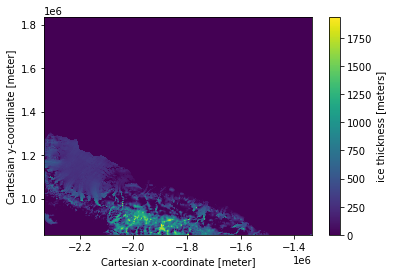

In [7]:
bm.thickness.isel(x=slice(2000,4000), y = slice(3000, 5000)).plot()

## this is all pretty slow, so if your are in ooi.pangio.io, start a cluster as follows

In [5]:
# get the dask-gateway version
dask_gateway.__version__
# show the default dask-gateway settings
dask.config.config['gateway']
#default gateway call
gateway = dask_gateway.Gateway()
# default new_cluster call
cluster = gateway.new_cluster()

In [6]:
#gateway = Gateway()
gateway.list_clusters()


[ClusterReport<name=ooi-prod.bab4ec2a10bf4a739633b35c7ce9b17d, status=RUNNING>]

In [7]:
# the dashboard_link property will show the link that can be pasted into the Dask labextension
cluster.dashboard_link

'/services/dask-gateway/clusters/ooi-prod.bab4ec2a10bf4a739633b35c7ce9b17d/status'

In [8]:
# scale cluster to 48 workers using the scale() method
cluster.scale(8)

In [9]:
# connect a client
# the distributed client is used for running parallel tasks with Dask
client = Client(cluster)

In [10]:
cluster

In [28]:
%%time
a = da.random.normal(size=(10000, 100000), chunks=(500, 500))
f = client.submit(a.std().compute)
#a.std().compute()
f.result()

KeyboardInterrupt: 

## try coursening on the cluster

In [45]:
H = bm.thickness
Hmean = H.mean()
H

<xarray.DataArray 'thickness' (y: 13300, x: 13300)>
dask.array<getitem, shape=(13300, 13300), dtype=float32, chunksize=(800, 800), chunktype=numpy.ndarray>
Coordinates:
  * x        (x) int32 -3333000 -3332500 -3332000 ... 3315500 3316000 3316500
  * y        (y) int32 3333000 3332500 3332000 ... -3315500 -3316000 -3316500
Attributes:
    long_name:      ice thickness
    standard_name:  land_ice_thickness
    units:          meters
    grid_mapping:   mapping
    source:         Mathieu Morlighem

In [44]:
#f = client.submit(bmmean.compute())
Hmean.compute()

distributed.protocol.core - CRITICAL - Failed to Serialize
Traceback (most recent call last):
  File "/srv/conda/envs/notebook/lib/python3.7/site-packages/distributed/protocol/core.py", line 54, in dumps
    for key, value in data.items()
  File "/srv/conda/envs/notebook/lib/python3.7/site-packages/distributed/protocol/core.py", line 55, in <dictcomp>
    if type(value) is Serialize
  File "/srv/conda/envs/notebook/lib/python3.7/site-packages/distributed/protocol/serialize.py", line 277, in serialize
    raise TypeError(msg, str(x)[:10000])
TypeError: ('Could not serialize object of type ImplicitToExplicitIndexingAdapter.', 'ImplicitToExplicitIndexingAdapter(array=CopyOnWriteArray(array=LazilyOuterIndexedArray(array=<xarray.backends.h5netcdf_.H5NetCDFArrayWrapper object at 0x7f10dafa58f0>, key=BasicIndexer((slice(None, None, None), slice(None, None, None))))))')
distributed.comm.utils - ERROR - ('Could not serialize object of type ImplicitToExplicitIndexingAdapter.', 'ImplicitToExplici

CancelledError: 

In [ ]:
bm_subset.hvplot.image(rasterize=True, aspect='equal', clim=(0,1800))